In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/dataset/midv_2020.zip

Archive:  gdrive/My Drive/dataset/midv_2020.zip
   creating: tmask/
   creating: tmask/photo/
   creating: tmask/photo/annotations/
  inflating: tmask/photo/annotations/alb_id.json  
  inflating: tmask/photo/annotations/esp_id.json  
   creating: tmask/photo/images/
   creating: tmask/photo/images/alb_id/
  inflating: tmask/photo/images/alb_id/00.jpg  
  inflating: tmask/photo/images/alb_id/01.jpg  
  inflating: tmask/photo/images/alb_id/02.jpg  
  inflating: tmask/photo/images/alb_id/03.jpg  
  inflating: tmask/photo/images/alb_id/04.jpg  
  inflating: tmask/photo/images/alb_id/05.jpg  
  inflating: tmask/photo/images/alb_id/06.jpg  
  inflating: tmask/photo/images/alb_id/07.jpg  
  inflating: tmask/photo/images/alb_id/08.jpg  
  inflating: tmask/photo/images/alb_id/09.jpg  
  inflating: tmask/photo/images/alb_id/10.jpg  
  inflating: tmask/photo/images/alb_id/11.jpg  
  inflating: tmask/photo/images/alb_id/12.jpg  
  inflating: tmask/photo/images/alb_id/13.jpg  
  inflating: tmask/ph

In [ ]:
import json

# reads the json file with the annotations of id cards
def readAnnotationsFile(jsonFile):
  try:
      with open(jsonFile, "r") as read_file:
        data = json.load(read_file)
        return data
  except FileNotFoundError:
    print(f"No such file or directory exists: '{jsonFile}'")
    return None

# retrieves the image name, and the coordinates of id card position in the image
def retrieveImageAttributes(jsonFile):
    
    # data contains the json data read from the json file
    data = readAnnotationsFile(jsonFile)
    
    if(data):
        imageAttributesList = []                            # list to contain attributes of all images in the json file
        imageMetadata = data["_via_img_metadata"]           # metadata of image in which the coordinates are present  
        imageIdList = data["_via_image_id_list"]            # names of images in the metadata

        for img in imageIdList:

            fileName = imageMetadata[img]['filename']                          # filename to which the ground truth image wil be stored
            regions = imageMetadata[img]['regions']
            all_points_x = regions[1]['shape_attributes']['all_points_x']      # all x coordinates  
            all_points_y = regions[1]['shape_attributes']['all_points_y']      # all y coordinates
            imageAttributesList.append((fileName,all_points_x,all_points_y))   

        return imageAttributesList                                             # list of tuples containing (filename, x coordinates and y coordinates) for every image
    else:
        return None

In [ ]:
import numpy as np
from skimage.draw import polygon
import cv2 as cv

# creates groud truth mask from all_points_x and all_points_y of four cornres of ID card in the image
def groundTruth(y_len, x_len, row_arr, col_arr, writeFileName):
    img = np.zeros((y_len, x_len), dtype=np.uint8)
    r = np.array(row_arr)
    c = np.array(col_arr)
    rr, cc = polygon(r,c)
    img[rr,cc] = 255
    
    cv.imwrite(writeFileName, img)

In [ ]:
import os 

# creates a new directory 
def createDirectory(filePath, newDirectory):
    path = os.path.join(filePath, newDirectory)
    os.mkdir(path)
    
    return path
# creates ground truth mask at the specified path given
def createMask(filePath, fileName, imgHeight, imgWidth, all_points_y, all_points_x):

    writeFilePath = os.path.join(filePath, fileName)
    groundTruth(imgHeight, imgWidth, all_points_y, all_points_x, writeFilePath)

In [ ]:
PHOTO_HEIGHT = 4032                     # height of images in photos folder
PHOTO_WIDTH = 2268                      # width of images in photos folder

SCAN_HEIGHT = 3507                      # height of images in scanned_rotated and scanned_upright folder
SCAN_WIDTH = 2480                       # width of images in  scanned_rotated and scanned_upright folder

PATH_PREFIX = 'tmask'                   # name of the folder containing the dataset

pathSuffix = ["annotations/alb_id.json", "annotations/esp_id.json"]
idClass = ["alb_id", "esp_id"]



typePath = ["photo", "scan_rotated", "scan_upright"]

# creates ground truth mask for Albanian and Spanish ID cards in the entire dataset
for fol in typePath:
    maskDir = createDirectory(os.path.join(PATH_PREFIX, fol), "mask")
    for i in range(len(pathSuffix)):
        imageAttributeList = retrieveImageAttributes(os.path.join(PATH_PREFIX, fol, pathSuffix[i]))
        idPath = createDirectory(maskDir, idClass[i])

        if imageAttributeList:
          for img in imageAttributeList:
              if(fol == "photo"):
                  createMask(idPath, img[0], PHOTO_HEIGHT, PHOTO_WIDTH, img[2], img[1])
              else:
                  createMask(idPath, img[0], SCAN_HEIGHT, SCAN_WIDTH, img[2], img[1])
        else:
          print('empty')

# approx 4 minute running time

In [ ]:
import shutil

src_path = "tmask"
dst_path = "dataset"
destination = shutil.copytree(src_path, dst_path) 


In [ ]:
TEMP_PATH_PREFIX = "dataset"
IMG_PATH_SUFFIX = ["images", "mask"]

In [ ]:
imageNumbering = [0, 100, 200, 300, 400 ,500]

FINAL_DATA_FOLDER = "data"
FINAL_IMG_PATH = os.path.join(FINAL_DATA_FOLDER, IMG_PATH_SUFFIX[0])
FINAL_MASK_PATH = os.path.join(FINAL_DATA_FOLDER, IMG_PATH_SUFFIX[1])
os.mkdir(FINAL_DATA_FOLDER)
os.mkdir(FINAL_IMG_PATH)
os.mkdir(FINAL_MASK_PATH)

imgNum = 0
for path in typePath:
  imgPath = FINAL_IMG_PATH
  for fol in IMG_PATH_SUFFIX:
    for cls in idClass:
      idPath = os.path.join(TEMP_PATH_PREFIX,path,fol,cls)
      if(len(os.listdir(idPath))==100):
        if(cls == "alb_id"):
          tmp_ = imgNum
        else:
          tmp_ = imgNum + 3
        for i in range(0,100):
          fileName = f"{i:02}"+str(".jpg")
          newName = f"{(imageNumbering[tmp_]+i):02}"+str(".jpg")
          os.rename(os.path.join(idPath,fileName),os.path.join(imgPath,newName))
      else:
        print("Files not read proerly")
    imgPath = FINAL_MASK_PATH
  imgNum += 1
  break


In [ ]:
shutil.rmtree("dataset")

In [ ]:
import os
imageNames = os.listdir("data/images")
maskNames = os.listdir("data/mask")

In [ ]:
imageNames.sort()

In [ ]:
maskNames.sort()

In [ ]:
for i in range(1,200):
  if(imageNames[i] != maskNames[i]):
    print(imageNames[i])
    print(maskNames[i])
    print("------------------------")
  

In [ ]:
print(imageNames[81])
print(maskNames[81])

346.jpg
346.jpg


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imageNames, maskNames, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
print(len(X_train), len(y_train))

120 120


In [ ]:
print(len(X_val), len(y_val))

40 40


In [ ]:
print(len(X_test), len(y_test))

40 40


In [ ]:
X_train[0]

'310.jpg'

In [ ]:
X_val[0]

'303.jpg'

In [ ]:
256*2

512

In [ ]:
def read_images(image_list):
  temp_image_list = []
  for image in image_list:
    orig_img = cv.imread(os.path.join("data/images",image))
    res_img = cv.resize(orig_img, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_image_list.append(tf.constant(res_img))
  return temp_image_list

def read_masks(mask_list):
  temp_mask_list = []
  for mask in mask_list:
    orig_msk = cv.imread(os.path.join("data/mask",mask),cv.IMREAD_GRAYSCALE)
    res_msk = cv.resize(orig_msk, (256,256), interpolation=cv.INTER_NEAREST)/255
    temp_mask_list.append(tf.constant(np.expand_dims(res_msk,axis=2)))
  return temp_mask_list

In [ ]:
# all_data = []
# all_images = [(X_train, y_train),(X_val, y_val),(X_test, y_test)]
# for tup in all_images:
#   temp_images = temp_masks = []
#   for image, mask in zip(tup[0], tup[1]):
    
    
#   break
#   all_data.append(temp_images)
#   all_data.append(temp_masks)
# approx 1m 49s

In [ ]:
train_images = read_images(X_train)
train_masks = read_masks(y_train)
val_images = read_images(X_val)
val_masks = read_masks(y_val)
test_images = read_images(X_test)
test_masks = read_masks(y_test)

# approx 1m 40s

NameError: ignored

In [ ]:
len(train_images)

120

In [ ]:
len(train_masks)

120

In [ ]:
len(val_images)

40

In [ ]:
len(val_masks)

40

In [ ]:
len(test_images)

40

In [ ]:
len(test_masks)

40

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices()

In [ ]:
# for element in train_data:
#   train_dataset_trial = tf.data.Dataset.from_tensor_slices(element)
#   print(element)
#   break

In [ ]:
# s = next(iter(train_dataset))

In [ ]:
# train_data[0]

In [ ]:
# for i in range(25):
#   cv2_imshow(np.squeeze(train_data[i]['image']))
#   tjk = np.squeeze(train_data[i]['segmentation_mask']).copy()
#   tjk[tjk == 1] = 255
#   cv2_imshow(tjk)
#   cv2_imshow(np.squeeze(val_data[i]['image']))
#   tjk = np.squeeze(val_data[i]['segmentation_mask']).copy()
#   tjk[tjk == 1] = 255
#   cv2_imshow(tjk)
#   cv2_imshow(np.squeeze(test_data[i]['image']))
#   tjk = np.squeeze(test_data[i]['segmentation_mask']).copy()
#   tjk[tjk == 1] = 255
#   cv2_imshow(tjk)

In [ ]:
# def resize(input_image, input_mask):
#    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
#    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

#    return input_image, input_mask

In [ ]:
# def augment(input_image, input_mask):
#    if tf.random.uniform(()) > 0.5:
#        # Random flipping of the image and mask
#        input_image = tf.image.flip_left_right(input_image)
#        input_mask = tf.image.flip_left_right(input_mask)

#    return input_image, input_mask

In [ ]:
# def normalize(input_image, input_mask):
#    input_image = tf.cast(input_image, tf.float32) / 255.0
#   #  input_mask -= 1
#    return input_image, input_mask

In [ ]:
# def load_image(datapoint):
#    input_image = datapoint["image"]
#    input_mask = datapoint["segmentation_mask"]
#    input_image, input_mask = resize(input_image, input_mask)
#    input_image, input_mask = augment(input_image, input_mask)
#    input_image, input_mask = normalize(input_image, input_mask)

#    return input_image, input_mask

# def load_image_test(datapoint):
#    input_image = datapoint["image"]
#    input_mask = datapoint["segmentation_mask"]
#    input_image, input_mask = resize(input_image, input_mask)
#    input_image, input_mask = normalize(input_image, input_mask)

#    return input_image, input_mask

In [ ]:
# values1 = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
# values2 = tf.constant([('AB','CD'), ('EF','GH'), ('IJ','KL')]) # ==> 3x1 tensor
# datasettt = tf.data.Dataset.from_tensor_slices((values1, values2))

In [ ]:
# for i in datasettt:
#   print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'A'>, <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'AB', b'CD'], dtype=object)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'B'>, <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'EF', b'GH'], dtype=object)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'A'>, <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'IJ', b'KL'], dtype=object)>)


In [ ]:
# len(all_data[2])

240

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

In [ ]:
# j = 0
# for i in test_dataset:
#   if j == 10:
#     break
#   tmp_tup = i
#   cv2_imshow(np.squeeze(tmp_tup[0]*255))
#   cv2_imshow(np.squeeze(tmp_tup[1]*255))
#   j += 1

In [ ]:
# for ele in train_batches:
#   print(ele)
#   break

In [ ]:
# train_dataset = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_dataset = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
BATCH_SIZE = 16
train_batches = train_dataset.batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_batches = val_dataset.batch(BATCH_SIZE).repeat()
val_batches = val_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_batches = test_dataset.batch(BATCH_SIZE).repeat()
test_batches = test_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

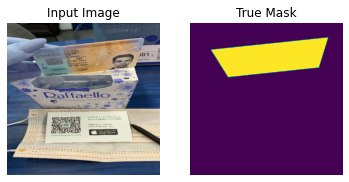

In [ ]:
def display(display_list):
 plt.figure()

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(512,512,3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_19[0][0]']              
                                )                                                             

In [ ]:
len(train_dataset)

120

In [ ]:
def MyCallback():
  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer]
  return callbacks

# # inheritance for training process plot 
# class PlotLearning(keras.callbacks.Callback):

#     def on_train_begin(self, logs={}):
#         self.i = 0
#         self.x = []
#         self.losses = []
#         self.val_losses = []
#         self.acc = []
#         self.val_acc = []
#         self.logs = []
#     def on_epoch_end(self, epoch, logs={}):
#         self.logs.append(logs)
#         self.x.append(self.i)
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))
#         self.acc.append(logs.get('mean_iou'))
#         self.val_acc.append(logs.get('val_mean_iou'))
#         self.i += 1
#         print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
  

#         if(logs.get('mean_iou')>0.97):
#           print("\nReached 97% accuracy cancelling training")
#           self.model.stop_training = True

In [ ]:
NUM_EPOCHS = 40

TRAIN_LENGTH = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# VAL_SUBSPLITS = 5
TEST_LENTH = len(val_dataset)
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE 

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_batches,
                               callbacks=[MyCallback()])

Epoch 1/40


In [ ]:
temp_test = next(iter(test_dataset))

In [ ]:
PREDICT_LENGTH = len(test_dataset)
PREDICTION_STEPS = PREDICT_LENGTH // BATCH_SIZE

In [ ]:
pred = unet_model.predict(x=test_batches,
                          steps=PREDICTION_STEPS, verbose=0)

In [ ]:
pred.shape

(32, 256, 256, 3)

In [ ]:
pred[0].shape

(256, 256, 3)

In [ ]:
# first_batch = next(iter(test_dataset))

In [ ]:
# for i in test_batches:
#   res = i
#   break

In [ ]:
# print(res)

In [ ]:
# test_dataset.shape

In [ ]:
import matplotlib
from google.colab import files

def pred_masks(predictions, test_batch):
  for batch in test_batch:
    first_batch = batch
    break
  true_images = first_batch[0]
  true_masks = first_batch[1]

  curr_iter = 0
  max_imgs = 20
  all_images = []
  # res_path = createDirectory('/content/','prediction')
  for true_img, true_msk, pred_msk in zip(true_images, true_masks, predictions):
    comparison = []
    img = np.squeeze(true_img).copy()*255
    msk = np.squeeze(true_msk).copy()*255
    msk = np.stack((msk,)*3, axis=-1)
    res = pred_msk.copy()
    res = res[:,:,0]
    res[res >= 0.9] = 255
    res[res < 0.9] = 0
    res = np.stack((res,)*3, axis=-1)
    comparison = np.concatenate((img,msk,res), axis=1)
    cv2_imshow(comparison)

    # temp_comparison = comparison.copy()
    # temp_comparison = temp_comparison.astype(int)
    # temp_comparison = np.uint8(temp_comparison)

    # img_write = os.path.join(res_path,f'{curr_iter}.png')
    # matplotlib.image.imsave(img_write, temp_comparison)
    # files.download(img_write)
    curr_iter += 1
    if curr_iter == 20:
      break

In [ ]:
# shutil.rmtree("prediction")

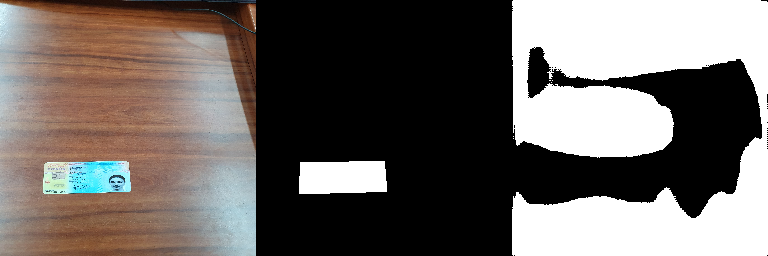

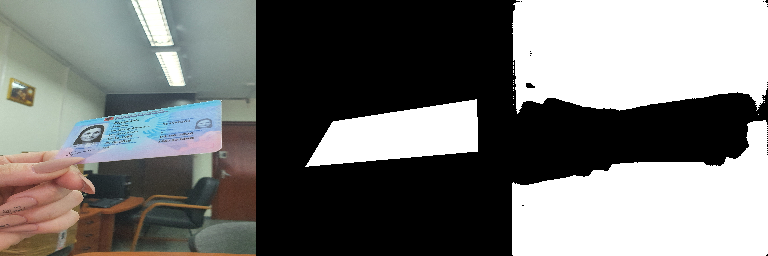

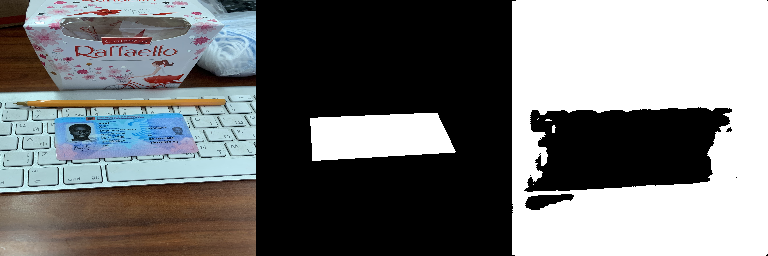

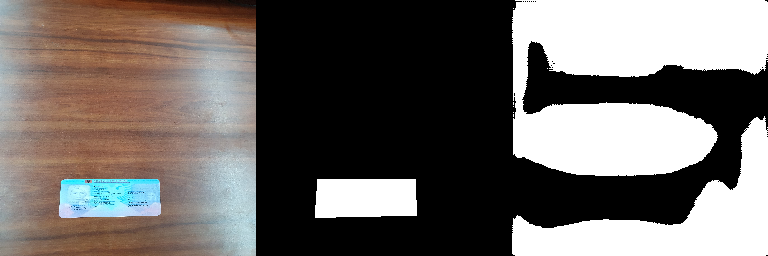

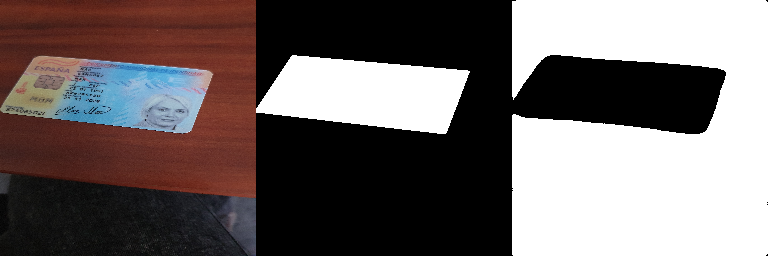

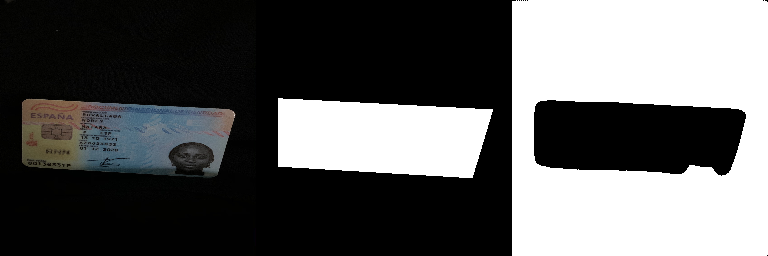

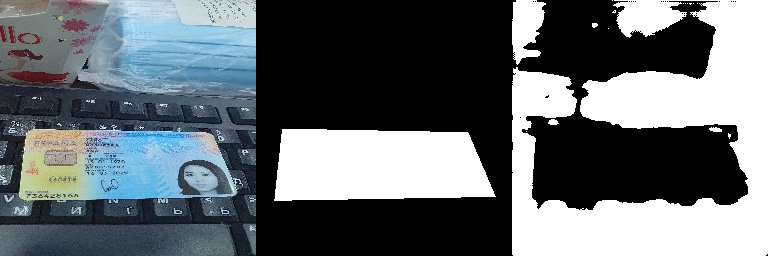

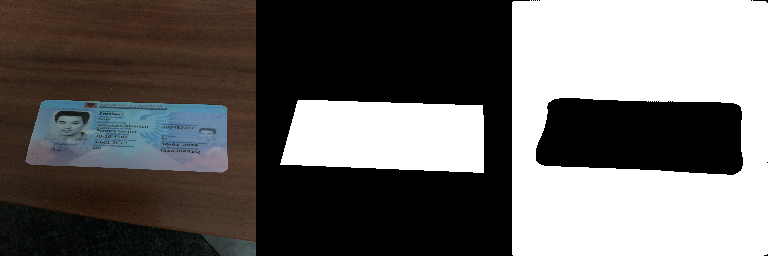

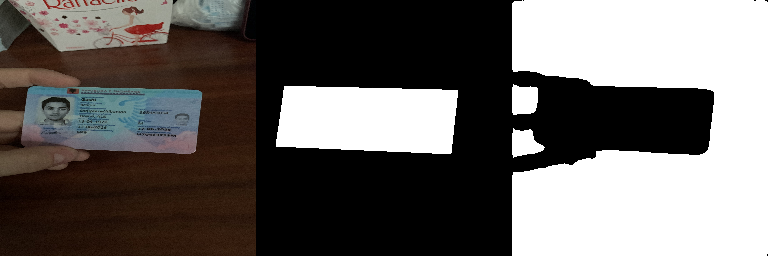

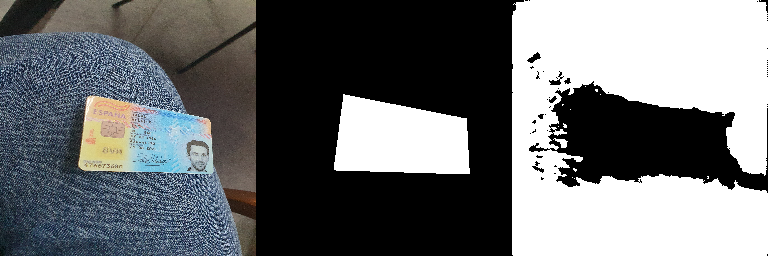

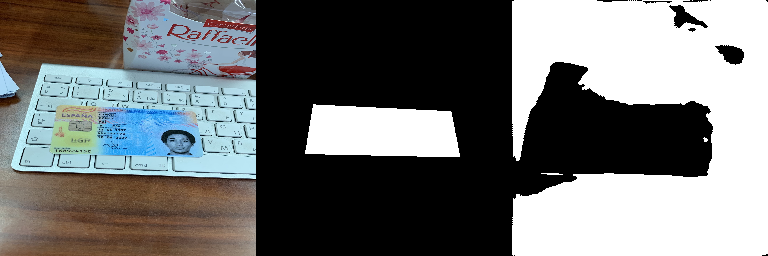

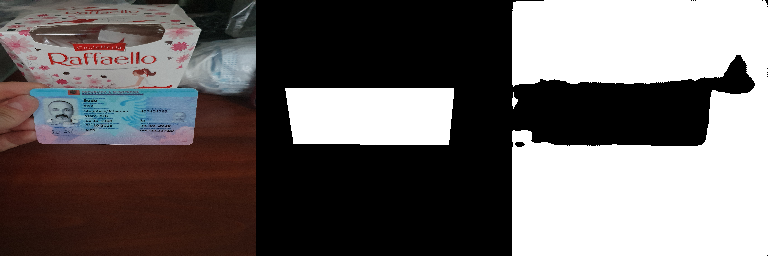

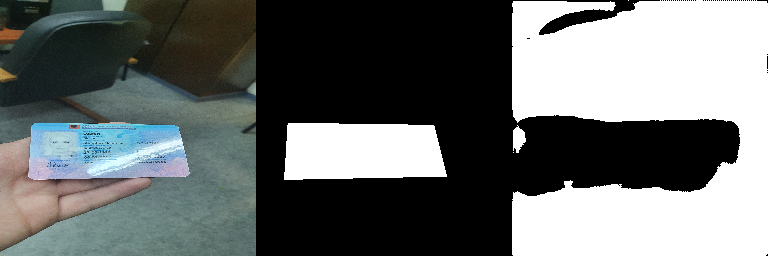

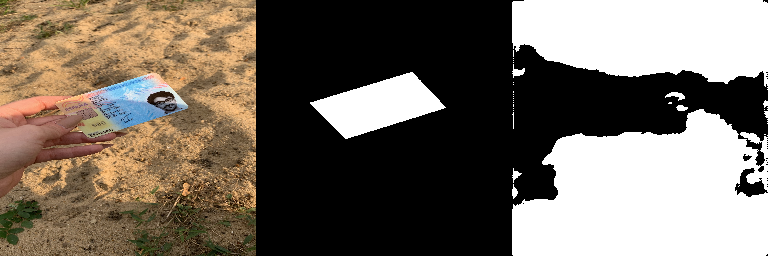

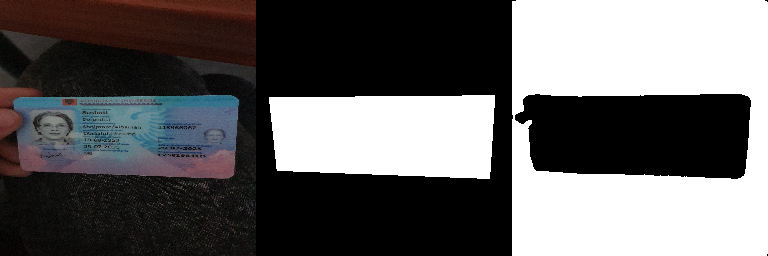

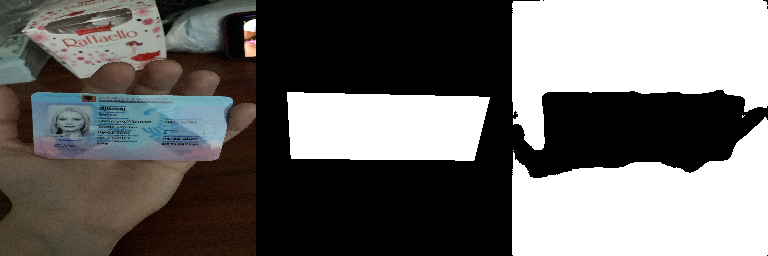

In [ ]:
pred_masks(pred, test_batches)

In [ ]:
t = write_img.copy()

In [ ]:
t = t.astype(int)
t = np.uint8(t)

In [ ]:
import matplotlib

matplotlib.image.imsave("/content/0.jpg", t)

In [ ]:
from google.colab import files
files.download("/content/0.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cv.imwrite("C:/Users/rathi/Desktop/results/0.jpg",write_img)

False

In [ ]:
# j = 0
# for i in pred:
#   if j == 1:
#     tmp_pred = i.copy()
#     break
#   j += 1

In [ ]:
# j = 0
# for i in test_dataset:
#   if j == 1:
#     test_1 = i
#     break
#   j += 1

In [ ]:
# tmp_pred.shape

(128, 128, 3)

In [ ]:
# gray = tmp_pred[:,:,0]

In [ ]:
# gray.shape

(128, 128)

In [ ]:
# print(min(np.unique(gray)))
# print(max(np.unique(gray)))
# # print(np.median(np.unique(gray)))

0.07407239
0.9998901
0.9980358


In [ ]:
# gray_copy = gray.copy()
# gray_copy[gray_copy >= 0.8] = 255
# gray_copy[gray_copy < 0.8] = 0

In [ ]:
# np.unique(gray_copy)

array([  0., 255.], dtype=float32)

In [ ]:
# test_1 = next(iter(test_dataset))

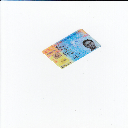

In [ ]:
# cv2_imshow(np.squeeze(test_1[0]*255))

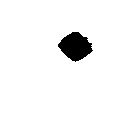

In [ ]:
# cv2_imshow(gray_copy)

In [ ]:
# 0.9998901

In [ ]:
# mo_loss, mo_accuracy = unet_model.evaluate(test_batches,steps=PREDICTION_STEPS, verbose=1)

1/1 [==============================] - 0s 368ms/step - loss: 0.1343 - accuracy: 0.9408
